In [6]:
from typing import TypedDict, Annotated, Sequence
from langchain import tools
from langgraph.graph.message import add_messages
from get_sub import list_available_languages, fetch_youtube_srt
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, AIMessage, ToolMessage, HumanMessage 
from langchain_core.messages import ToolMessage
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
import re # For SRT parsing
from prompts import SUBTITLE_EXTRACTION_SYSTEM_PROMPT

load_dotenv()

class AgentState(TypedDict):
    video_link: str
    original_language: str  # User-input original language name (e.g., "English", "Chinese")
    target_language: str
    
    # Fields for subtitle extraction flow
    available_languages: list | None = None # Stores result of list_available_languages
    chosen_language_code: str | None = None  # Agent-selected language code (e.g., "en")
    original_srt_path: str | None = None    # File path of the original saved SRT from fetch_youtube_srt
    
    # Message history, managed by add_messages
    messages: Annotated[Sequence[BaseMessage], add_messages]


def input_node(state:AgentState) -> AgentState:
    '''Ask user to enter
        - video_link: str
        - original_language: str
        - target_language: str
    '''
    video_link = input('Enter the youtube link:')
    state['video_link'] = video_link
    original_language = input('What language of sub you want to translate?')
    state['original_language'] = original_language
    target_language = input('What language sub do you want?')
    state['target_language'] = target_language

    # System prompt is now imported from prompts.py
    system_prompt = SUBTITLE_EXTRACTION_SYSTEM_PROMPT
    
    human_message_content = (
        f"Video URL: {state['video_link']}, "
        f"Original Language: {state['original_language']}, "
        f"Target Language: {state['target_language']}"
    )

    initial_messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=human_message_content)
    ]
    state['messages'] = initial_messages
    return state

tools = [list_available_languages, fetch_youtube_srt]

llm = ChatOpenAI(model='gpt-4o').bind_tools(tools)

def get_sub_node(state: AgentState) -> dict:
    """Main reasoning node. 
    Checks for tool outputs, calls LLM, and prepares state updates.
    """
    messages = state['messages']
    updates_to_state = {}

    # Process output from the last tool call, if any.
    if messages and isinstance(messages[-1], ToolMessage):
        last_message = messages[-1]
        if last_message.name == "list_available_languages":
            updates_to_state["available_languages"] = last_message.content
        elif last_message.name == "fetch_youtube_srt":
            # Store the path to the saved SRT file.
            updates_to_state["original_srt_path"] = last_message.content
    
    # Call LLM for the next action.
    ai_response = llm.invoke(messages)
    
    # Add LLM's response to messages.
    updates_to_state["messages"] = [ai_response]

    # If LLM calls fetch_youtube_srt, store the chosen language code.
    if ai_response.tool_calls:
        for tool_call in ai_response.tool_calls:
            if tool_call['name'] == "fetch_youtube_srt":
                if isinstance(tool_call['args'], dict):
                    updates_to_state["chosen_language_code"] = tool_call['args'].get('language_code')
                break # Assuming only one call to fetch_youtube_srt at a time
    
    return updates_to_state

def should_continue(state: AgentState) -> str:
    """Determines the next step after the 'getsub' node.

    Returns:
        str: 'continue_extraction' to call a tool for subtitle extraction,
             'start_translation' if original SRT is ready for translation,
             'end_process' to stop if extraction fails or no further action.
    """
    if state.get("original_srt_path") is not None:
        # Original SRT is fetched, proceed to translation preparation
        return "start_translation"

    messages = state['messages']
    if not messages:
        return "end_process"  # Safety stop

    last_message = messages[-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "continue_extraction" # LLM called a tool for extraction
    
    # No tool call from LLM, and original_srt_path is not set, so end.
    return "end_process"

# Placeholder node functions for the translation workflow
def prepare_translation_node(state: AgentState) -> dict:
    return

def generate_translation_context_node(state: AgentState) -> dict:
    return

def translate_current_chunk_node(state: AgentState) -> dict:
    return

def aggregate_translation_node(state: AgentState) -> dict:
    return

def should_translate_more_chunks(state: AgentState) -> str:
    return

def finalize_translation_node(state: AgentState) -> dict:
    return

# Graph definition
graph = StateGraph(AgentState)

# Nodes for subtitle extraction
graph.add_node('input', input_node)
graph.add_node('getsub', get_sub_node)
tool_node = ToolNode(tools=tools)
graph.add_node('tools', tool_node)

# Nodes for subtitle translation (placeholders)
graph.add_node('prepare_translation', prepare_translation_node)
graph.add_node('generate_translation_context', generate_translation_context_node)
graph.add_node('translate_current_chunk', translate_current_chunk_node)
graph.add_node('aggregate_translation', aggregate_translation_node)
graph.add_node('finalize_translation', finalize_translation_node)

# Edges for subtitle extraction flow
graph.add_edge(START, 'input')
graph.add_edge('input', 'getsub')

graph.add_conditional_edges(
    'getsub',
    should_continue,
    {
        'continue_extraction': 'tools',
        'start_translation': 'prepare_translation',
        'end_process': END
    }
)
graph.add_edge('tools', 'getsub') # Loop back for more tool calls if needed during extraction

# Edges for subtitle translation flow
graph.add_edge('prepare_translation', 'generate_translation_context')
graph.add_edge('generate_translation_context', 'translate_current_chunk')
graph.add_edge('translate_current_chunk', 'aggregate_translation')

graph.add_conditional_edges(
    'aggregate_translation',
    should_translate_more_chunks,
    {
        'continue_translation': 'translate_current_chunk', # Loop for next chunk
        'finish_translation': 'finalize_translation'      # All chunks translated
    }
)
graph.add_edge('finalize_translation', END)

app = graph.compile()

# app.invoke({})



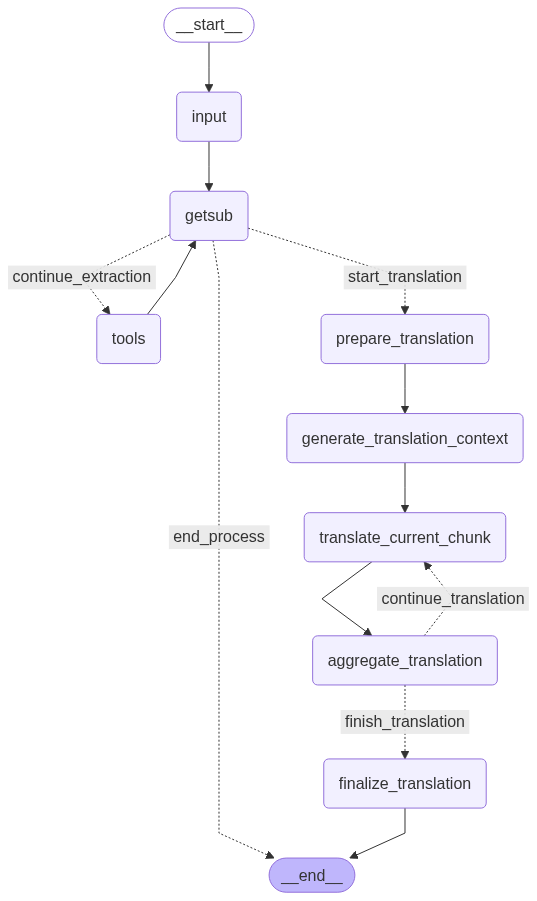

In [7]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))